In [3]:
# 1. 数据读入：使用新的销售数据文件
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import xgboost as xgb
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller as ADF
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 读取销售数据，同时解析销售日期
sales_df = pd.read_csv("sql/glass_processing_sales_data_single_company.csv", parse_dates=['销售日期'])

# 查看数据（可选）
print(sales_df.head())

       企业名称    销售区域  产品名称  销售数量   原价   销售价格       销售额   净利率       销售日期
0  铜仁玻璃有限公司  贵州省铜仁市  单片玻璃   178  150  225.0   40050.0  0.33 2024-12-29
1  铜仁玻璃有限公司  贵州省铜仁市  夹层玻璃    37  350  735.0   27195.0  0.52 2024-11-02
2  铜仁玻璃有限公司  贵州省铜仁市  双层玻璃   169  400  920.0  155480.0  0.57 2024-04-01
3  铜仁玻璃有限公司  贵州省铜仁市  夹层玻璃   116  350  735.0   85260.0  0.52 2024-01-07
4  铜仁玻璃有限公司  贵州省铜仁市  夹层玻璃   188  350  735.0  138180.0  0.52 2024-03-21


In [4]:

# 2. 针对不同玻璃种类，可以选择按产品名称分组建模，也可以直接整体预测
# 这里以整体数据为例，同时预测三个指标：
# 销售价格、销售额、净利率

# 提取目标变量：假设我们以时间序列方式预测，每个指标按销售日期排序
sales_df.sort_values(by='销售日期', inplace=True)
sales_df.set_index('销售日期', inplace=True)

# 分别提取三个目标指标的序列
price_series = sales_df['销售价格']
revenue_series = sales_df['销售额']
margin_series = sales_df['净利率']

# 例如：针对销售价格的预测
model_price = sm.tsa.SARIMAX(price_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
SARIMA_price = model_price.fit()
print(SARIMA_price.summary())

C:\Users\13441\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\13441\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               销售价格   No. Observations:                12541
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood              -88771.459
Date:                            Tue, 15 Apr 2025   AIC                         177552.918
Time:                                    00:59:09   BIC                         177590.081
Sample:                                         0   HQIC                        177565.360
                                          - 12541                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0051      0.009      0.564      0.573      -0.013       0.023
ma.L1         -1.0000      0.013   

C:\Users\13441\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\13441\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


TypeError: 'RangeIndex' object is not callable

C:\Users\13441\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\13441\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 21806 (\N{CJK UNIFIED IDEOGRAPH-552E}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\13441\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\13441\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\13441\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJ

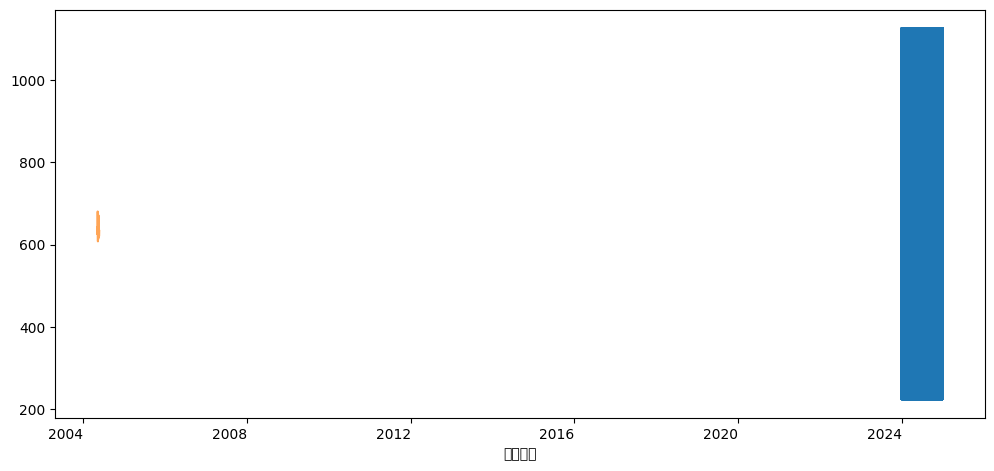

In [6]:

# 绘制销售价格的预测结果
forecast_price = SARIMA_price.get_forecast(steps=20)  # 预测未来20个时间点
fig, ax = plt.subplots(figsize=(12, 6))
price_series.plot(ax=ax, label='历史销售价格')
forecast_price.predicted_mean.plot(ax=ax, label='预测销售价格', alpha=0.7)
ax.fill_between(forecast_price.conf_int().index(),
                forecast_price.conf_int().iloc[:, 0],
                forecast_price.conf_int().iloc[:, 1],
                color='grey', alpha=0.3)
ax.set_xlabel("销售日期")
ax.set_ylabel("销售价格")
ax.legend()
plt.show()

In [7]:

model_revenue = sm.tsa.SARIMAX(revenue_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
SARIMA_revenue = model_revenue.fit()
print(SARIMA_revenue.summary())

forecast_revenue = SARIMA_revenue.get_forecast(steps=20)
fig, ax = plt.subplots(figsize=(12, 6))
revenue_series.plot(ax=ax, label='历史销售额')
forecast_revenue.predicted_mean.plot(ax=ax, label='预测销售额', alpha=0.7)
ax.fill_between(forecast_revenue.conf_int().index(),
                forecast_revenue.conf_int().iloc[:, 0],
                forecast_revenue.conf_int().iloc[:, 1],
                color='grey', alpha=0.3)
ax.set_xlabel("销售日期")
ax.set_ylabel("销售额")
ax.legend()
plt.show()

model_margin = sm.tsa.SARIMAX(margin_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
SARIMA_margin = model_margin.fit()
print(SARIMA_margin.summary())

forecast_margin = SARIMA_margin.get_forecast(steps=20)
fig, ax = plt.subplots(figsize=(12, 6))
margin_series.plot(ax=ax, label='历史净利率')
forecast_margin.predicted_mean.plot(ax=ax, label='预测净利率', alpha=0.7)
ax.fill_between(forecast_margin.conf_int().index(),
                forecast_margin.conf_int().iloc[:, 0],
                forecast_margin.conf_int().iloc[:, 1],
                color='grey', alpha=0.3)
ax.set_xlabel("销售日期")
ax.set_ylabel("净利率")
ax.legend()
plt.show()

# 3. 如果需要结合机器学习模型（如XGBoost）来预测指标，也可以类似修改：
# 构造特征（例如，利用日期特征、产品种类的虚拟变量等）——这里仅作为示例使用销售日期的时间戳作为唯一特征

# 将销售日期转换为数值型特征（例如时间戳）
sales_df['timestamp'] = sales_df.index.astype(np.int64) // 10 ** 9  # 单位：秒

# 构造XGBoost预测销售价格的示例
X = sales_df[['timestamp']]
y_price = sales_df['销售价格']

# 划分训练集与测试集（示例中直接使用全部数据）
xgb_price_model = xgb.XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1)
xgb_price_model.fit(X, y_price)

# 预测并计算误差
price_pred = xgb_price_model.predict(X)
print("XGBoost销售价格预测 - MSE:", mean_squared_error(y_price, price_pred))
plt.figure(figsize=(10, 6))
plt.plot(y_price.values, label='真实销售价格')
plt.plot(price_pred, label='XGBoost预测销售价格')
plt.legend()
plt.show()


# 同样方式可以构造销售额和净利率的XGBoost预测模型

# 4. 结合时间序列模型和机器学习模型的预测结果（例如，采用加权融合）：
def update_weights(sarima_pred, xgb_pred, P, Q, R):
    # 计算卡尔曼增益
    K = P / (P + R)
    # 更新权重
    updated_weight = sarima_pred + K * (xgb_pred - sarima_pred)
    # 更新P
    P = P - K * P + Q
    return updated_weight, P


# 假设针对销售价格，我们分别获得SARIMA和XGBoost的预测
sarima_price_pred = forecast_price.predicted_mean  # SARIMA预测值（Series类型）
# 为保持维度一致，这里简单地取XGBoost在预测区间对应的值
# 注意：实际中需要构造合适的预测时间特征
xgb_price_pred = xgb_price_model.predict(np.array(sarima_price_pred.index.astype(np.int64) // 10 ** 9).reshape(-1, 1))

# 初始化卡尔曼滤波参数
P, Q, R = 1, 0.1, 0.1
updated_weight, P = update_weights(sarima_price_pred, xgb_price_pred, P, Q, R)
final_price_prediction = updated_weight * sarima_price_pred + (1 - updated_weight) * xgb_price_pred
print("融合预测销售价格：", final_price_prediction)

plt.figure(figsize=(10, 6))
plt.plot(price_series[-50:], label='历史销售价格')
plt.plot(final_price_prediction, label='融合预测销售价格')
plt.legend()
plt.show()


C:\Users\13441\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\13441\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyboardInterrupt: 